In [66]:
import numpy as np
from math import floor
import torch.optim as optim
from matplotlib import pyplot as plt
from importlib import reload
import sobol_seq
import fcn # FCN is the module built from scratch. 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF

reload(fcn)

<module 'fcn' from '/home/glitchinthematrix/Desktop/EE-761/MAB-Hyperparameter-Tuning/fcn.py'>

In [46]:
#Preprocessing and Bifurcating  in Train and Test
"""
This block preprocesses images before they can be trained upon.
It does the followng:
- Scales the images betweeen 0 and 1
- Concatenates the HOG features to the flattened images
- Brings down the mean of the image to zero
- Dimensionality reduction using PCA. 3396 features to 1000 features
"""

data_raw = np.load('./dataset_2.npy')/255 #scaing images
labels = np.load('./dataset_2_label.npy')
hog_features = np.load('./dataset_2_hog.npy')[:,1:]
data= data_raw[1:,:]
labels = labels[:,1:]
y_train = labels[:,:9000]
y_test = labels[:,9000:]

X_train = data[:9000,:]
#X_trainm = X_train - np.mean(X_train, axis = 0) 
X_train = np.concatenate((X_train,hog_features[:,:9000].T),1) # Adding the HOG features in addition to the flattned attributes
X_trainm = X_train - np.mean(X_train, axis = 0) #Bringing mean down to 0
cov = np.dot(X_trainm.T, X_trainm) / X_trainm.shape[0] #Calculating covariance
U,S,V = np.linalg.svd(cov) #Calculating eigen vectors
X_train_uc = np.dot(X_trainm, U[:800].T) #Projecting to 1000 eigen vectors 

X_test = data[9000:,:]
#X_testm = X_test -  np.mean(X_train, axis = 0) 
X_test = np.concatenate((X_test,hog_features[:,9000:].T),1)
X_testm = X_test -  np.mean(X_train, axis = 0) 
X_test_uc = np.dot(X_testm, U[:800].T) 

#9000 train images and 1000 images in the test set


In [78]:
def run_config(config):
    print("Currently Sampling: {}".format(config))
    layers = [800,config[0],config[1],2]
    discriminator = fcn.Model(layers,load=False,learning_rate=config[2]) #Initialize architecture
    discriminator.LoadData(X_train_uc,y_train.T,X_test_uc,y_test.T) #Load test and train data
    epoch_vec,train_vec,test_vec = discriminator.train(epoch=30)
    print("Test acc is: {}".format(test_vec[-1]/100))
    return test_vec[-1]/100

    

In [79]:
def query(lr_low, lr_high,hidden1_low, hidden1_high, hidden2_low, hidden2_high,sobol):
    
    arm_lr = lr_low + sobol[0]*(lr_high-lr_low)
    arm_nh1 = hidden1_low +floor(sobol[1]*(hidden1_high - hidden1_low))
    arm_nh2 = hidden2_low + floor(sobol[2]*(hidden2_high - hidden2_low))
    
    return [arm_nh1,arm_nh2,arm_lr]  

def binarization(prob):
    
    if np.random.random() < prob:
        return 1
    else:
        return 0

In [80]:
#Define ranges, exploitation, exploration and pool space
t = 0
Budget = 100
lr_low = 1e-4
lr_high = 1e-5
nh1_low = 500
nh1_high = 550
nh2_low = 50
nh2_high = 100

exploitation_count = 2
exploration_count = 3
pool_count = 1200
seq = sobol_seq.i4_sobol_generate(3,pool_count)
pool = [query(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,sobol) for sobol in seq]

arms_query = []
arms_query_acc = []
beta = 0.9

narms = 0
wins_arm = []
lose_arm = []



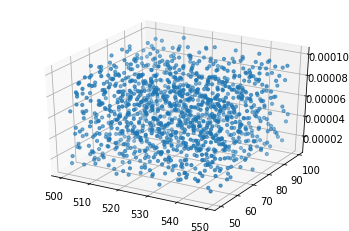

In [81]:
#Visualize pool space

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1), pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)

In [82]:
#Start sampling

while t<Budget:
    print("Exploring")
    for i in range(exploration_count):
        query_index = floor(np.random.random()*(len(pool)-1))
        popped = pool.pop(query_index)
        arms_query.append(popped)
        wins_arm.append(0)
        lose_arm.append(0)
        arms_query_acc.append(0)
        acc = run_config(arms_query[-1])
        arms_query_acc[-1] = acc
        
        binary = binarization(acc)
        wins_arm[-1] += binary
        lose_arm[-1] += 1-binary
        narms+=1
    
    print("Exploiting")
    reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
    I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    if np.random.random() > beta:
        
        reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
        I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    for arm in I_1:
        acc = run_config(arms_query[arm])
        binary = binarization(acc)
        wins_arm[arm] += binary
        lose_arm[arm] += 1-binary
        arms_query_acc[arm] = (arms_query_acc[arm]*(wins_arm[arm]+lose_arm[arm] - 1) + acc) / (wins_arm[arm]+lose_arm[arm]) 

    t+=1
        
        


Exploring
Currently Sampling: [500, 85, 4.39697265625e-05]
Test acc is: 0.708
Currently Sampling: [521, 76, 1.9580078125e-05]
Test acc is: 0.561
Currently Sampling: [512, 78, 5.4384765625e-05]
Test acc is: 0.723
Exploiting
Currently Sampling: [512, 78, 5.4384765625e-05]
Test acc is: 0.716
Currently Sampling: [521, 76, 1.9580078125e-05]
Test acc is: 0.666
Exploring
Currently Sampling: [514, 76, 8.048828125000001e-05]
Test acc is: 0.72
Currently Sampling: [518, 69, 4.41015625e-05]
Test acc is: 0.715
Currently Sampling: [521, 80, 5.0078125e-05]
Test acc is: 0.709
Exploiting
Currently Sampling: [521, 76, 1.9580078125e-05]
Test acc is: 0.609
Currently Sampling: [521, 80, 5.0078125e-05]
Test acc is: 0.711
Exploring
Currently Sampling: [547, 72, 8.9892578125e-05]
Test acc is: 0.725
Currently Sampling: [520, 73, 6.9326171875e-05]
Test acc is: 0.718
Currently Sampling: [538, 72, 9.560546875e-05]
Test acc is: 0.73
Exploiting
Currently Sampling: [514, 76, 8.048828125000001e-05]
Test acc is: 0.721

Test acc is: 0.711
Currently Sampling: [519, 90, 9.3232421875e-05]
Test acc is: 0.718
Exploiting
Currently Sampling: [541, 58, 5.69775390625e-05]
Test acc is: 0.713
Currently Sampling: [543, 89, 5.0957031250000004e-05]
Test acc is: 0.7120000000000001
Exploring
Currently Sampling: [532, 59, 7.5390625e-05]
Test acc is: 0.7189999999999999
Currently Sampling: [541, 86, 3.1357421875e-05]
Test acc is: 0.687
Currently Sampling: [508, 83, 1.0878906249999997e-05]
Test acc is: 0.603
Exploiting
Currently Sampling: [543, 73, 4.4189453125e-05]
Test acc is: 0.7019999999999998
Currently Sampling: [534, 95, 6.0185546875000004e-05]
Test acc is: 0.715
Exploring
Currently Sampling: [530, 63, 1.6591796875000005e-05]
Test acc is: 0.586
Currently Sampling: [528, 69, 9.424316406250001e-05]
Test acc is: 0.723
Currently Sampling: [529, 51, 1.8085937499999995e-05]
Test acc is: 0.65
Exploiting
Currently Sampling: [520, 67, 5.4033203125000004e-05]
Test acc is: 0.713
Currently Sampling: [543, 89, 5.095703125000000

Test acc is: 0.722
Exploring
Currently Sampling: [542, 55, 1.650390625e-05]
Test acc is: 0.587
Currently Sampling: [545, 75, 7.855468750000001e-05]
Test acc is: 0.72
Currently Sampling: [518, 66, 1.72509765625e-05]
Test acc is: 0.569
Exploiting
Currently Sampling: [523, 54, 3.5927734375e-05]
Test acc is: 0.696
Currently Sampling: [501, 74, 9.103515625e-05]
Test acc is: 0.715
Exploring
Currently Sampling: [535, 82, 7.5478515625e-05]
Test acc is: 0.713
Currently Sampling: [530, 55, 2.5996093750000005e-05]
Test acc is: 0.6780000000000002
Currently Sampling: [530, 73, 7.1171875e-05]
Test acc is: 0.715
Exploiting
Currently Sampling: [542, 55, 1.650390625e-05]
Test acc is: 0.571
Currently Sampling: [510, 75, 9.1298828125e-05]
Test acc is: 0.722
Exploring
Currently Sampling: [526, 76, 5.9306640625e-05]
Test acc is: 0.7070000000000001
Currently Sampling: [549, 78, 9.516601562500001e-05]
Test acc is: 0.7239999999999999
Currently Sampling: [520, 56, 6.326171875e-05]
Test acc is: 0.71700000000000

Test acc is: 0.714
Currently Sampling: [537, 62, 7.75e-05]
Test acc is: 0.715
Exploring
Currently Sampling: [501, 55, 2.9599609375000004e-05]
Test acc is: 0.684
Currently Sampling: [509, 54, 5.6933593750000004e-05]
Test acc is: 0.7120000000000001
Currently Sampling: [526, 70, 9.718750000000001e-05]
Test acc is: 0.725
Exploiting
Currently Sampling: [516, 55, 6.44921875e-05]
Test acc is: 0.716
Currently Sampling: [531, 68, 8.1279296875e-05]
Test acc is: 0.7120000000000001
Exploring
Currently Sampling: [501, 57, 8.6552734375e-05]
Test acc is: 0.72
Currently Sampling: [528, 90, 5.6142578125e-05]
Test acc is: 0.71
Currently Sampling: [526, 72, 8.189453125e-05]
Test acc is: 0.72
Exploiting
Currently Sampling: [537, 62, 7.75e-05]
Test acc is: 0.7170000000000001
Currently Sampling: [515, 76, 7.24462890625e-05]
Test acc is: 0.7120000000000001
Exploring
Currently Sampling: [517, 71, 8.3916015625e-05]
Test acc is: 0.7189999999999999
Currently Sampling: [532, 73, 2.95556640625e-05]
Test acc is: 0.

Test acc is: 0.7019999999999998
Currently Sampling: [539, 94, 4.4804687500000004e-05]
Test acc is: 0.7120000000000001
Exploring
Currently Sampling: [509, 77, 3.4521484375000006e-05]
Test acc is: 0.695
Currently Sampling: [500, 56, 2.4941406249999993e-05]
Test acc is: 0.69
Currently Sampling: [549, 73, 8.158691406250001e-05]
Test acc is: 0.715
Exploiting
Currently Sampling: [539, 74, 6.7041015625e-05]
Test acc is: 0.713
Currently Sampling: [506, 80, 4.3310546875e-05]
Test acc is: 0.711
Exploring
Currently Sampling: [505, 64, 8.154296875e-05]
Test acc is: 0.7189999999999999
Currently Sampling: [519, 68, 4.0102539062500004e-05]
Test acc is: 0.679
Currently Sampling: [517, 51, 3.9091796875e-05]
Test acc is: 0.711
Exploiting
Currently Sampling: [517, 71, 8.3916015625e-05]
Test acc is: 0.7120000000000001
Currently Sampling: [519, 84, 9.6220703125e-05]
Test acc is: 0.721
Exploring
Currently Sampling: [500, 60, 7.310546875000001e-05]
Test acc is: 0.714
Currently Sampling: [537, 96, 7.767578125

1192
[[528, 67, 8.69921875e-05], [511, 75, 1.7382812499999996e-05], [519, 77, 2.8149414062500003e-05], [533, 72, 7.670898437500001e-05], [502, 69, 2.6259765624999997e-05], [532, 51, 4.09375e-05], [516, 63, 4.05859375e-05], [518, 53, 8.1630859375e-05], [534, 84, 7.240234375000001e-05], [526, 70, 9.718750000000001e-05], [541, 60, 4.568359375e-05], [547, 66, 7.943359375e-05], [534, 88, 7.20947265625e-05], [522, 92, 3.1313476562499996e-05], [515, 82, 6.0537109375e-05], [508, 80, 7.6533203125e-05], [542, 58, 7.090820312500001e-05], [532, 94, 2.5556640625e-05], [511, 82, 2.7841796874999994e-05], [501, 95, 5.21875e-05], [533, 66, 6.484375e-05], [510, 91, 5.8427734375e-05], [541, 88, 2.3095703125000004e-05], [531, 97, 7.3720703125e-05], [527, 74, 4.90234375e-05], [547, 67, 7.63134765625e-05], [547, 75, 3.8388671875e-05], [509, 68, 8.330078125e-05], [526, 71, 2.5688476562499995e-05], [506, 82, 6.660156250000001e-05], [549, 53, 2.79296875e-05]]


In [105]:
def normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,inp):
    inp[:,0] = (inp[:,0] - nh1_low)/(nh1_high - nh1_low)
    inp[:,1] = (inp[:,1] - nh2_high)/(nh2_high - nh2_low)
    inp[:,2] = (inp[:,2] - lr_low)/(lr_high - lr_low)
    return inp

In [135]:
# Accuracy Predictor
#Train

k = 1.1 ** 2 * RBF(length_scale=0.1) #Check parameters
X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(arms_query).reshape(-1,3))
y = np.array(arms_query_acc).reshape(-1,1)
test_X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(pool).reshape(-1,3))

gp = GPR(kernel=k, alpha=0.001, optimizer='fmin_l_bfgs_b',normalize_y=False)
gp.fit(X,y)
y_pred, y_std = gp.predict(test_X, return_std=True)
print("Best query arms is {} with accuracy of : {} ".format(arms_query[np.argmax(arms_query_acc)],arms_query_acc[np.argmax(arms_query_acc)]))

print("Best pool arms is {} with accuracy of : {} ".format(pool[np.argmax(y_pred)],y_pred[np.argmax(y_pred),0]))

Best query arms is [501, 75, 9.701171875000001e-05] with accuracy of : 0.735 
Best pool arms is [549, 86, 7.706054687500001e-05] with accuracy of : 0.729701005382541 


In [137]:
run_config(pool[np.argmax(y_pred)])

Currently Sampling: [549, 86, 7.706054687500001e-05]
Test acc is: 0.7189999999999999


0.7189999999999999

[0.71072429 0.65558508 0.72240557 0.72531831 0.72573219]
